In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Modelo CNN con generador, embedings de smiles y data-augmentation

In [90]:
import pandas as pd
import numpy as np
from datagen import smiles_dict, smiles_to_seq

### smiles_dict

In [91]:
len(smiles_dict)

42

smiles_dict nos da un tokenizador para simplificar el problema. Puede ver como se construyó en la notebook **deep_chem**.
Si al momento de correr el modelo con este diccionario encuentra problemas de key_error, puede agregar los faltantes al diccionario

Mirar dentro de **datagen.py** como se usa este diccionario con la función **smiles_to_seq** para tokenizar. El código es muy sencillo

In [92]:
print(smiles_dict)

{'#': 1, '(': 2, ')': 3, '+': 4, '-': 5, '/': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '=': 15, 'C': 16, 'F': 17, 'H': 18, 'I': 19, 'N': 20, 'O': 21, 'P': 22, 'S': 23, '[': 24, '\\': 25, ']': 26, '_': 27, 'c': 28, 'Cl': 29, 'Br': 30, 'n': 31, 'o': 32, 's': 33, '@': 34, '.': 35, 'a': 36, 'B': 37, 'e': 38, 'i': 39, '9': 40, '10': 41, '11': 42}


# Carga de los datos

In [93]:
df = pd.read_csv('data/acetylcholinesterase_02_bioactivity_data_preprocessed.csv')

In [94]:
max_len_idx = df['canonical_smiles'].apply(len).argmax()
min_len_idx = df['canonical_smiles'].apply(len).argmin()
max_sequence_len = len(df['canonical_smiles'].iloc[max_len_idx]) + 20

In [95]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,300.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,800.0,6.096910


In [96]:
X = df['canonical_smiles'].values
y = df['pIC50'].values

# Data augmentation:

https://arxiv.org/pdf/1703.07076.pdf

https://github.com/EBjerrum/molvecgen

https://github.com/Ebjerrum/SMILES-enumeration

En la publicación de arriba se describe una técnica de aumentación de datos para los smiles. Leerla si es de su interes (Opcional)

En el módulo **dataug.py**, tomando como referencia los repositorios arriba citados se implementó la aumentación de datos

In [97]:
seq = 'CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'

from dataaug import SmilesEnumerator
sme = SmilesEnumerator()
for i in range(10):
    print(sme.randomize_smiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'))

c1(OCC)oc(=O)n(-c2cc(OCc3ccccc3)ccc2)n1
c1(=O)n(-c2cc(OCc3ccccc3)ccc2)nc(OCC)o1
c1c(COc2cccc(-n3nc(OCC)oc3=O)c2)cccc1
CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
c1c(COc2cccc(-n3c(=O)oc(OCC)n3)c2)cccc1
c1(COc2cc(-n3nc(OCC)oc3=O)ccc2)ccccc1
c1c(-n2nc(OCC)oc2=O)cccc1OCc1ccccc1
c1cc(OCc2ccccc2)cc(-n2nc(OCC)oc2=O)c1
c1(OCC)nn(-c2cc(OCc3ccccc3)ccc2)c(=O)o1
CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1


In [98]:
from dataaug import SmilesEnumerator
sme = SmilesEnumerator()
for i in range(10):
    print(sme.randomize_smiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'))
    

CCOc1oc(=O)n(-c2cccc(OCc3ccccc3)c2)n1
c1c(COc2cc(-n3c(=O)oc(OCC)n3)ccc2)cccc1
C(Oc1cccc(-n2nc(OCC)oc2=O)c1)c1ccccc1
n1c(OCC)oc(=O)n1-c1cc(OCc2ccccc2)ccc1
c1c(OCc2ccccc2)cccc1-n1nc(OCC)oc1=O
c1ccc(COc2cc(-n3nc(OCC)oc3=O)ccc2)cc1
c1c(-n2nc(OCC)oc2=O)cccc1OCc1ccccc1
c1c(OCc2ccccc2)cccc1-n1nc(OCC)oc1=O
n1(-c2cccc(OCc3ccccc3)c2)c(=O)oc(OCC)n1
n1c(OCC)oc(=O)n1-c1cccc(OCc2ccccc2)c1


# DataGenerator

Construir un generador al que se le pase al instanciarlo:
- X: smiles (formula química)
- y: pIC50
- batch_size
- max_sequence_len (int): La máxima longitud de las secuencias (para hacer el padding)
- data_augmentation (boolean): si quiero hacer o no data-augmentation. 
- shuffle (boolean)

Guardarlo en el módulo **datagen.py** con el nombre de la clase **DataGenerator**

Notar que el módulo **datagen.py** ya tiene una estructura para completar

### Importamos el módulo y lo probamos

In [99]:
from datagen import DataGenerator

In [100]:
max_sequence_len

224

In [101]:
dgen = DataGenerator(X, y, max_sequence_len, batch_size=16)

In [102]:
len(dgen) * dgen.batch_size

6160

In [103]:
for i, (X_b, y_b) in enumerate(dgen):
    print(f'{i}\r', end='')

In [104]:
X_b

array([[28,  7,  2, ...,  0,  0,  0],
       [21, 15, 16, ...,  0,  0,  0],
       [29, 35, 16, ...,  0,  0,  0],
       ...,
       [21, 15, 28, ...,  0,  0,  0],
       [28,  7,  8, ...,  0,  0,  0],
       [28,  7, 28, ...,  0,  0,  0]])

In [105]:
y_b.shape

(13,)

# Split

In [106]:
from sklearn.model_selection import train_test_split

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [108]:
X_train.shape

(4925,)

In [109]:
X_train = X_train[:4500]
y_train = y_train[:4500]

In [110]:
len(X_train), len(y_train), len(X_test)

(4500, 4500, 1232)

In [111]:
X_train

array(['COc1cc(/C=C/c2ccc3ccccc3[n+]2C)ccc1N1CCOCC1.[I-]',
       'CCCCCCCNC(=O)Oc1ccc2c(c1)C1(C)CCN(CC)C2C1',
       'c1ccc2c(COc3nn(CCN4CCCC4)c4ccccc34)cccc2c1', ...,
       'Cl.Nc1c2c(nc3ccc(F)cc13)CCC2',
       'CCN(CC)CCCCCOc1ccc(C(=O)/C=C/c2ccccc2)cc1',
       'COc1ccccc1/C=C1\\CN(C(=O)C[C@H]2C[C@H]3CCCN3[C@]23C(=O)Nc2ccccc23)C/C(=C\\c2ccccc2OC)C1=O'],
      dtype=object)

In [112]:
dgen_train = DataGenerator(X_train, y_train, seq_length=max_sequence_len, batch_size=128, data_augmentation=True)
dgen_test = DataGenerator(X_test, y_test, seq_length=max_sequence_len, batch_size=128, data_augmentation=False)

In [113]:
dgen_train

In [114]:
for i, (X_b, y_b) in enumerate(dgen_test):
    print(f'{i}\r', end='')

# Network Model

In [115]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, Activation, BatchNormalization, Conv1D, MaxPool1D, GlobalAveragePooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers as L

In [116]:
def text_cnn_1d(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters):
    input_x = L.Input(shape=(sequence_length,), name='input_x')
    
    # Embedding layer
    embedding = L.Embedding(input_dim=vocab_size, output_dim=embedding_size)(input_x)
    
    pooled_outputs = []
    for filter_size in filter_sizes:
        # Convolutional layer
        conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu')(embedding)
        
        # Max pooling layer
        max_p = L.MaxPooling1D(pool_size=sequence_length - filter_size + 1)(conv)
        
        pooled_outputs.append(max_p)
        
    h_pool = L.Concatenate(axis=2)(pooled_outputs)
    dense = L.Flatten()(h_pool)
    
    # Batch normalization
    normalized_layer = L.BatchNormalization()(dense)
    
    # Fully connected layers
    dense = L.Dense(128, activation='relu')(normalized_layer)
    dense = L.Dropout(0.5)(dense)  # Adding dropout for regularization
    dense = L.Dense(64, activation='relu')(dense)  # Adding another dense layer
    
    # Output layer
    output_layer = L.Dense(1, activation='linear')(dense)  # Assuming pIC50 is a continuous value
    
    model = tf.keras.models.Model(input_x, output_layer)
    return model

In [117]:
# Puede cambiar estos hiperparámtros. Son solo de referencia
FILTER_SIZES = (3, 4, 5)
NUM_FILTERS = 128
vocab_size = len(smiles_dict) + 1
embeddings_size = 128 # 2

In [118]:
del(model)

In [119]:
model = text_cnn_1d(max_sequence_len, vocab_size, embeddings_size, FILTER_SIZES, NUM_FILTERS)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_x (InputLayer)        [(None, 224)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 224, 128)             5504      ['input_x[0][0]']             
                                                                                                  
 conv1d_6 (Conv1D)           (None, 222, 128)             49280     ['embedding_2[0][0]']         
                                                                                                  
 conv1d_7 (Conv1D)           (None, 221, 128)             65664     ['embedding_2[0][0]']         
                                                                                            

In [120]:
# model.summary()

In [121]:
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [88]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[R2])
history = model.fit(dgen_train, epochs=100, validation_data=dgen_test)

Epoch 1/100
36/36 [==============================] - 7s 129ms/step - loss: 33.6837 - R2: -13.0642 - val_loss: 34.1184 - val_R2: -13.0987
Epoch 2/100
36/36 [==============================] - 5s 125ms/step - loss: 22.7360 - R2: -8.4343 - val_loss: 31.6567 - val_R2: -12.1793
Epoch 3/100
36/36 [==============================] - 5s 127ms/step - loss: 10.3571 - R2: -3.2974 - val_loss: 28.0975 - val_R2: -10.4678
Epoch 4/100
36/36 [==============================] - 5s 125ms/step - loss: 5.0652 - R2: -1.1065 - val_loss: 25.8018 - val_R2: -9.5770
Epoch 5/100
36/36 [==============================] - 5s 128ms/step - loss: 4.0619 - R2: -0.6725 - val_loss: 25.2527 - val_R2: -9.6400
Epoch 6/100
36/36 [==============================] - 5s 125ms/step - loss: 3.7609 - R2: -0.5970 - val_loss: 24.4449 - val_R2: -8.9891
Epoch 7/100
36/36 [==============================] - 5s 127ms/step - loss: 3.5251 - R2: -0.4576 - val_loss: 23.5869 - val_R2: -8.8094
Epoch 8/100
36/36 [==============================] - 5s

In [ ]:
mcp = ModelCheckpoint('models/best_model_{epoch}', save_best_only=True, save_format="h5")

In [ ]:
history = model.fit(dgen_train, epochs=10, validation_data=dgen_test)

In [43]:
X_test_eval = []
y_t_eval = []
for X_t, y_t in dgen_test:
    X_test_eval = X_test_eval + [list(t) for t in X_t]
    y_t_eval = y_t_eval + list(y_t)
X_test_eval = np.array(X_test_eval)
y_test = np.array(y_t_eval)

In [44]:
X_test_eval.shape, y_test.shape

((1232, 224), (1232,))

In [45]:
y_pred = model.predict(X_test_eval)

39/39 [==============================] - 1s 17ms/step


# Score

In [46]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

In [47]:
r2

0.3767816676835821

In [48]:
filename = 'models/embed_128_text_cnn_aug_100x100_0.0001.h5'
model.save(filename)

/home/nando/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [49]:
# model.summary()

# Load model (solo si se grabo el modelo)

In [50]:
from tensorflow.keras.models import load_model

In [51]:
model_loaded = load_model(filename, custom_objects={'R2': R2})

In [52]:
y_pred = model_loaded.predict(X_test_eval)

39/39 [==============================] - 1s 17ms/step


In [53]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
r2

0.3767816676835821

# Evaluación

<function matplotlib.pyplot.show(close=None, block=None)>

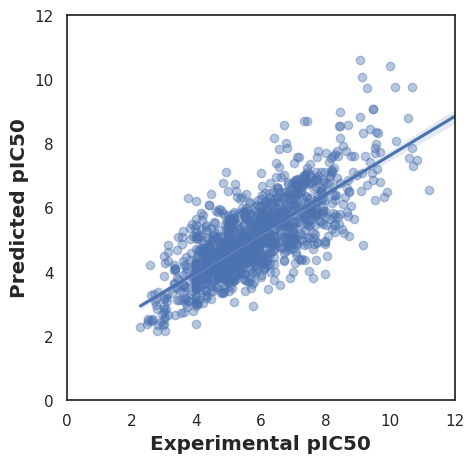

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show